In [1]:
import os
import random
import gdown
import tensorflow as tf
from tensorflow import keras

INPUT_SIZE = (224, 224)
CUSTOM_MODEL_NAME = 'custom-mobnet-pretrained'

WORKING_PATHS = {
    'BASE': os.path.join('workspace'),
    'DATASET': os.path.join('workspace', 'dataset'),
    'TRAIN_DATASET': os.path.join('workspace', 'dataset', 'train'),
    'TEST_DATASET': os.path.join('workspace', 'dataset', 'test'),
    'OUTPUT': os.path.join('workspace', 'output'),
    'EXPORT': os.path.join('workspace', 'output', CUSTOM_MODEL_NAME, 'export', 'hand-sign-bisindo'),
    'TFLITE':os.path.join('workspace', 'output', CUSTOM_MODEL_NAME, 'tfliteexport'),
    'JSON':os.path.join('workspace', 'output', CUSTOM_MODEL_NAME, 'json'),
 }

In [2]:
# Create working dirs
for path in WORKING_PATHS.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [3]:
print("Training labels:", os.listdir(WORKING_PATHS['TRAIN_DATASET']))
print("Testing labels:", os.listdir(WORKING_PATHS['TEST_DATASET']))

Training labels: []
Testing labels: []


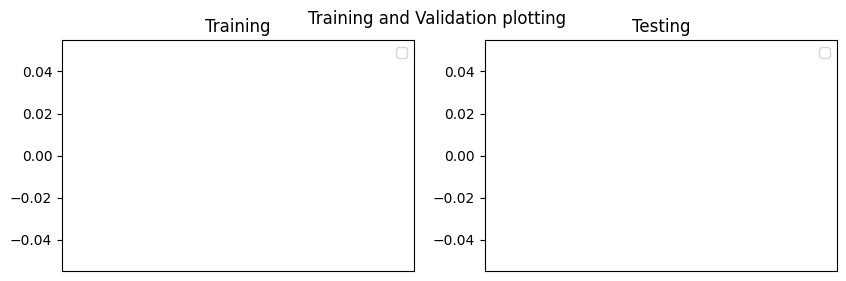

In [4]:
# Check total dataset each labels
import numpy as np
import matplotlib.pyplot as plt

static_labels = os.listdir(WORKING_PATHS['TRAIN_DATASET'])
TRAIN_IMG_MIN = 9999
train_data_num = {}
test_data_num = {}

for label in static_labels:
    train_data_num[label] = len(os.listdir(os.path.join(WORKING_PATHS['TRAIN_DATASET'], label)))
    test_data_num[label] = len(os.listdir(os.path.join(WORKING_PATHS['TEST_DATASET'], label)))
    if train_data_num[label] < TRAIN_IMG_MIN:
        TRAIN_IMG_MIN = train_data_num[label]

y_pos = np.arange(len(static_labels))
train_values = train_data_num.values()
test_values = test_data_num.values()

fig, axs = plt.subplots(1, 2, figsize = (10, 3))
fig.suptitle('Training and Validation plotting')
axs[0].bar(y_pos, train_values, align = 'center', alpha = 0.5)
axs[0].set_xticks(y_pos, static_labels)
axs[0].set_title('Training')
axs[0].legend()
axs[1].bar(y_pos, test_values, align = 'center', alpha = 0.5)
axs[1].set_xticks(y_pos, static_labels)
axs[1].set_title('Testing')
axs[1].legend()

plt.show()

In [5]:
# Requirement Lib Import
import math
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Random seed
seed = random.randint(0, TRAIN_IMG_MIN)

# plot matrix size
cols = 3
rows = math.ceil(len(static_labels) / 3)

# Show image plot
fig_size = 3
fig, axs = plt.subplots(rows, cols, figsize = ((fig_size * cols), (fig_size * rows)))
fig.suptitle('Random Selected Trainning Preview')
fig.tight_layout()
fig.subplots_adjust(top = 0.95)
axs = axs.ravel()

# Image training random selector
img_dict = {}
for idx, label in enumerate(static_labels):
    img_path = os.path.join(WORKING_PATHS['TRAIN_DATASET'], label)
    img_rand = os.listdir(img_path)[seed]
    img_selc = image.load_img(os.path.join(img_path, img_rand))

    axs[idx].imshow(img_selc.resize(INPUT_SIZE))
    axs[idx].set_title(label)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 900x0 with 0 Axes>

In [ ]:
# Dataset pre-processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
validation_datagen = ImageDataGenerator(rescale = 1 / 255)

train_generator = train_datagen.flow_from_directory(
    WORKING_PATHS['TRAIN_DATASET'],
    target_size = INPUT_SIZE,
    class_mode = 'categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    WORKING_PATHS['TEST_DATASET'],
    target_size = INPUT_SIZE,
    class_mode = 'categorical'
)

In [ ]:
# defined classes based on foldering structure, sort by alphabetical
LABELS = list(train_generator.class_indices.keys())
NUM_CLASSES = len(LABELS) # Set classes num
print(NUM_CLASSES)

In [ ]:
class EarlyStoppingAtGivenAccuracy(keras.callbacks.Callback):
    """
        Stop training when the accuracy at given threshold
    """
    def __init__(self, threshold = 0.9):
        super(EarlyStoppingAtGivenAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        acc = logs.get('accuracy')
        if acc is not None:
            if acc >= self.threshold:
                print('Epoch {}: Reached baseline, stop training'.format(epoch))
                self.model.stop_training = True

from tensorflow.keras.callbacks import Callback

class EarlyStoppingAtSeparateThresholds(Callback):
    """
    Stop training when training accuracy and validation accuracy
    each reach their respective thresholds.
    """
    def __init__(self, train_threshold=0.9, val_threshold=0.85):
        super(EarlyStoppingAtSeparateThresholds, self).__init__()
        self.train_threshold = train_threshold
        self.val_threshold = val_threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        # Check if training accuracy and validation accuracy reach their respective thresholds
        if train_acc is not None and val_acc is not None:
            if train_acc >= self.train_threshold and val_acc >= self.val_threshold:
                print(
                    f"Epoch {epoch}: Training accuracy reached {train_acc:.4f} (threshold: {self.train_threshold}) "
                    f"and validation accuracy reached {val_acc:.4f} (threshold: {self.val_threshold}), stopping training."
                )
                self.model.stop_training = True


In [ ]:
# from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV2

pre_trained_model = MobileNetV2(
    weights = 'imagenet',
    input_shape = (INPUT_SIZE[0], INPUT_SIZE[1], 3),
    include_top = False,
)

pre_trained_model.trainable = False

In [ ]:
# Fine Tuning
pre_trained_model.trainable = True

for layer in pre_trained_model.layers[:100]:
    layer.trainable = False

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam


x = layers.Flatten()(pre_trained_model.output)

x = layers.Dense(512, activation = 'relu')(x)

x = layers.Dropout(0.1)(x)

x = layers.Dense(NUM_CLASSES, activation = 'softmax')(x)

model = Model(inputs = pre_trained_model.input, outputs = x)

model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')
])

model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# callback = EarlyStoppingAtGivenAccuracy(0.97)
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 30,
    validation_steps = 5,
    verbose = 1,
    # callbacks = [callback]
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, axs = plt.subplots(2, 1, figsize = (5, 6))
fig.suptitle('Training and Validation plotting')
axs[0].plot(epochs, acc, 'r', label = 'Training accuracy')
axs[0].plot(epochs, val_acc, 'b', label = 'Validation accuracy')
axs[0].set_title('Training')
axs[0].legend()
axs[1].plot(epochs, loss, 'r', label = 'Training Loss')
axs[1].plot(epochs, val_loss, 'b', label = 'Validation Loss')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer = Adam(learning_rate = 0.000001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# Start Training!
callback = EarlyStoppingAtSeparateThresholds(train_threshold=0.99, val_threshold=0.95)
history2 = model.fit(
    train_generator,
    validation_data = validation_generator,
    initial_epoch = 30,
    epochs = 60,
    validation_steps = 5,
    verbose = 1,
    callbacks = [callback]
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs = range(len(acc) + len(acc2))

fig, axs = plt.subplots(2, 1, figsize = (10, 6))
fig.suptitle('Training and Validation plotting')
axs[0].plot(epochs, acc + acc2, 'r', label = 'Training accuracy')
axs[0].plot(epochs, val_acc + val_acc2, 'b', label = 'Validation Training accuracy')
axs[0].set_title('Training')
axs[0].legend()
axs[0].axvline(x = len(acc))
axs[1].plot(epochs, loss + loss2, 'r', label = 'Loss accuracy')
axs[1].plot(epochs, val_loss + val_loss2, 'b', label = 'Validation Loss accuracy')
axs[1].set_title('Loss')
axs[1].legend()
axs[1].axvline(x = len(acc))
plt.show()

In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def __init__(self, target_accuracy=0.98, max_val_loss=0.17):
        super().__init__()
        self.target_accuracy = target_accuracy
        self.max_val_loss = max_val_loss

    def on_epoch_end(self, epoch, logs=None):
        # Memeriksa apakah accuracy >= 0.95 dan validation loss <= 0.1
        val_loss = logs.get('val_loss')
        accuracy = logs.get('accuracy')

        if accuracy >= self.target_accuracy and val_loss <= self.max_val_loss:
            print(f"\nEpoch {epoch+1}: Accuracy is {accuracy:.4f} and validation loss is {val_loss:.4f}. Stopping training.")
            self.model.stop_training = True  # Menghentikan pelatihan

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer = Adam(learning_rate = 0.000001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# callback = EarlyStoppingAtSeparateThresholds(train_threshold=0.99, val_threshold=0.95)
custom_callback = CustomCallback(target_accuracy=0.98, max_val_loss=0.17)
history2 = model.fit(
    train_generator,
    validation_data = validation_generator,
    initial_epoch = 60,
    epochs = 90,
    validation_steps = 5,
    verbose = 1,
    callbacks = [custom_callback]
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs = range(len(acc) + len(acc2))

fig, axs = plt.subplots(2, 1, figsize = (10, 6))
fig.suptitle('Training and Validation plotting')
axs[0].plot(epochs, acc + acc2, 'r', label = 'Training accuracy')
axs[0].plot(epochs, val_acc + val_acc2, 'b', label = 'Validation Training accuracy')
axs[0].set_title('Training')
axs[0].legend()
axs[0].axvline(x = len(acc))
axs[1].plot(epochs, loss + loss2, 'r', label = 'Loss accuracy')
axs[1].plot(epochs, val_loss + val_loss2, 'b', label = 'Validation Loss accuracy')
axs[1].set_title('Loss')
axs[1].legend()
axs[1].axvline(x = len(acc))
plt.show()

In [ ]:
def selectRandomImage(labels = None):
    if labels == None:
        seed = random.randint(1, NUM_CLASSES)
        label_seed = LABELS[seed - 1]
    else:
        seed = random.randint(1, len(labels))
        label_seed = labels[seed - 1]

    path = os.path.join(WORKING_PATHS['TRAIN_DATASET'], label_seed)
    test_dir = os.listdir(path)
    test_dir_num = len(test_dir)
    file_name = os.listdir(path)[random.randint(0, test_dir_num - 1)]
    return (os.path.join(path, file_name), file_name, label_seed)

In [ ]:
def createResultPlot(prediction_list, prediction_label, actual_label, file_name):
    # Result Plot
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    fig.suptitle('Image {} predict as: {}'.format(file_name, prediction_label))
    fig.subplots_adjust(top = 2)
    fig.tight_layout()
    axs = axs.ravel()

    if prediction_label == actual_label:
        fig.patch.set_facecolor('xkcd:mint green')
    else:
        fig.patch.set_facecolor('xkcd:pale pink')

    axs[0].set_title(actual_label)
    axs[0].imshow(img)

    axs[1].set_title('Probabilities')
    axs[1].bar(range(0, NUM_CLASSES), prediction_list, align = 'center')
    axs[1].set_xticks(range(0, NUM_CLASSES))
    axs[1].set_xticklabels(LABELS)

    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


# file_path, file_name, label = selectRandomImage()
file_path, file_name, label = selectRandomImage(['Y'])
img = image.load_img(file_path, target_size = INPUT_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

prediction = model.predict(x, batch_size = 10)
index = int(prediction[0].argmax(axis = -1))

createResultPlot(prediction[0].reshape(NUM_CLASSES), LABELS[index], label, file_name)

In [ ]:
pip uninstall numpy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for label in LABELS:
    path = os.path.join(WORKING_PATHS['TEST_DATASET'], label)
    files = os.listdir(path)
    for idx, file_name in enumerate(files):
        file_loc = os.path.join(path, file_name)
        img = image.load_img(file_loc, target_size = INPUT_SIZE)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        x = preprocess_input(x)

        prediction = model.predict(x, batch_size = 10)
        index = int(prediction[0].argmax(axis = -1))
        y_true.append(label)
        y_pred.append(LABELS[index])
        # print('Image with label {} predicted as {}'.format(label, LABELS[index]))

mat = confusion_matrix(y_true, y_pred, labels = LABELS)

mat_norm = mat / mat.astype(np.float64).sum(axis = 1)

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# Buat DataFrame confusion matrix
df_cm = pd.DataFrame(mat_norm, index=LABELS, columns=LABELS)

# Perbesar ukuran gambar dan sesuaikan parameter
plt.figure(figsize=(20, 15))  # Perbesar ukuran lebih besar
ax = sn.heatmap(
    df_cm,
    annot=True,
    fmt=".2f",  # Format angka di setiap sel
    cmap="coolwarm",  # Gunakan colormap yang kontras
    annot_kws={"size": 10},  # Ukuran anotasi diperbesar
    linewidths=0.5,  # Tambahkan garis antar sel
    linecolor="black"  # Warna garis antar sel
)

# Set judul dan label
ax.set_title("Test Confusion Matrix", fontsize=20, pad=20)
ax.set_xlabel("Predicted Label", fontsize=16, labelpad=20)
ax.set_ylabel("True Label", fontsize=16, labelpad=20)

# Rotasi dan perbesar label sumbu X dan Y
plt.xticks(rotation=45, fontsize=12, ha="right")
plt.yticks(rotation=0, fontsize=12)

# Tampilkan plot
plt.tight_layout()  # Sesuaikan tata letak
plt.show()


In [ ]:
import os
import tensorflow as tf

# Define the export directory
export_dir = os.path.join(os.getcwd(), WORKING_PATHS['EXPORT'], 'hand-sign-bisindo')  # Change 'bisindo' to your desired model name

# Save the model in the SavedModel format
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(WORKING_PATHS['EXPORT']) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(os.path.join(WORKING_PATHS['TFLITE'], 'hand-sign-bisindo-model.tflite'), 'wb') as f:
  f.write(tflite_model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(WORKING_PATHS['EXPORT'])
tflite_model = converter.convert()

In [ ]:
import pathlib

In [ ]:
tflite_model_file = pathlib.Path('hand-sign-bisindo-model.tflite')
tflite_model_file.write_bytes(tflite_model)
print(f"Model disimpan di: {tflite_model_file}")

In [ ]:
import os
import tensorflow as tf

# Define the export directory
export_dir = os.path.join(os.getcwd(), WORKING_PATHS['EXPORT'], 'hand-sign-bisindo-model.h5')  # Ubah ke nama file yang diinginkan

# Save the model in H5 format
model.save(export_dir, save_format='h5')


In [ ]:
import os
import tensorflow as tf
import subprocess

# Tentukan direktori kerja dan path model H5
export_dir = os.path.join(os.getcwd(), WORKING_PATHS['EXPORT'])
h5_model_path = os.path.join(export_dir, 'hand-sign-bisindo-model.h5')

# Pastikan model disimpan dalam format H5
# model.save(h5_model_path, save_format='h5')
# print(f"Model saved in H5 format at: {h5_model_path}")

output_dir = os.path.join(os.getcwd(), WORKING_PATHS['JSON'])

# Tentukan path output untuk model TFJS
tfjs_output_dir = os.path.join(output_dir, 'tfjs-hand-sign-bisindo')

# Pastikan direktori output ada
os.makedirs(tfjs_output_dir, exist_ok=True)

# Gunakan tensorflowjs_converter untuk mengonversi model H5 ke format TFJS
subprocess.run([
    "tensorflowjs_converter",
    "--input_format", "keras",
    h5_model_path,
    tfjs_output_dir
])

print(f"Model successfully converted to TFJS format in: {tfjs_output_dir}")


In [ ]:
import tensorflow as tf
import numpy as np
from io import BytesIO
from PIL import Image
from IPython.display import display
import ipywidgets as widgets

# Memuat model TFLite
try:
    interpreter = tf.lite.Interpreter(model_path="hand-sign-bisindo-model.tflite")
    interpreter.allocate_tensors()
    print("Model berhasil dimuat.")
except Exception as e:
    print(f"Error saat memuat model: {e}")

# Mendapatkan detail input dan output model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Periksa ukuran input model
input_shape = input_details[0]['shape']
print(f"Input model shape: {input_shape}")

# Daftar kelas (A-Z)
classes = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
print(f"Kelas model: {classes}")

# Membuat widget untuk mengunggah file
uploader = widgets.FileUpload(accept="image/*", multiple=True)
clear_button = widgets.Button(description="Clear Output", button_style='danger')  # Tombol Clear Output
out = widgets.Output()

# Tampilkan widget
display(widgets.VBox([uploader, clear_button]))
display(out)

def clear_output_area(_):
    """Fungsi untuk membersihkan output prediksi."""
    with out:
        out.clear_output()
        print("Output telah dibersihkan.")

clear_button.on_click(clear_output_area)

def file_predict(filename, file, out):
    """Fungsi untuk memproses gambar, melakukan prediksi, dan menampilkan hasil."""
    try:
        # Memuat dan memproses gambar (ubah ukuran ke dimensi yang sesuai dengan model)
        image = tf.keras.utils.load_img(file, target_size=(input_shape[1], input_shape[2]))  # Sesuaikan ukuran
        image = tf.keras.utils.img_to_array(image)
        image = np.expand_dims(image, axis=0).astype(np.float32)  # Pastikan tipe data float32 sesuai model

        # Normalisasi gambar (jika diperlukan)
        image = image / 255.0  # Sesuaikan jika model Anda memerlukan normalisasi

        # Melakukan inferensi menggunakan model TFLite
        interpreter.set_tensor(input_details[0]['index'], image)
        interpreter.invoke()
        prediction = interpreter.get_tensor(output_details[0]['index'])[0]

        with out:
            # Menampilkan hasil prediksi
            print(f"\nFile: {filename}")
            print(f"Model output: {prediction}")

            # Ambil kelas dengan probabilitas tertinggi
            prediction_index = np.argmax(prediction)
            predicted_class = classes[prediction_index]
            print(f"Prediksi: {filename} adalah huruf {predicted_class}")

    except Exception as e:
        with out:
            print(f"Error saat memproses file {filename}: {e}")

def on_upload_change(change):
    """Fungsi untuk menangani file yang diunggah dan menjalankan prediksi."""
    items = change.new
    for item in items:
        try:
            print(f"Mengunggah file: {item.name}")
            file_jpgdata = BytesIO(item.content)
            file_predict(item.name, file_jpgdata, out)
        except Exception as e:
            print(f"Error saat menangani file {item.name}: {e}")

# Menghubungkan widget uploader ke fungsi
uploader.observe(on_upload_change, names='value')
print("Widget uploader terhubung. Silakan unggah file gambar.")
